In [1]:
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt
from scipy import signal
from operator import attrgetter
from functools import reduce

GRAY_CONVERTER = np.array([0.2989, 0.5870, 0.1140])
EPSILON = np.finfo(float).eps

train_path = r'.\Group_1\train'
test_path = r'.\Group_1\test'


Unable to revert mtime: /Library/Fonts
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [5]:
image = matplotlib.image.imread(os.path.join(train_path, 'bird', '0000.jpg'))


FileNotFoundError: [Errno 2] No such file or directory: '.\\Group_1\\train/bird/0000.jpg'

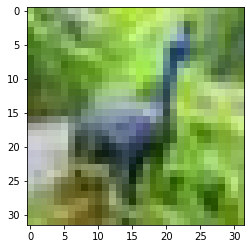

In [181]:
plt.imshow(image)
plt.show()

In [168]:
def relu(x):
    return np.where(x >= 0, x, 0)


def sigmoid(x):
    return np.apply_along_axis(lambda a: 1 / (1 + np.exp(-a)), 0, x)


def convert_to_gray(image):
    return np.dot(image[..., :3], GRAY_CONVERTER)


def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value


In [169]:
grayscale_image = convert_to_gray(image)


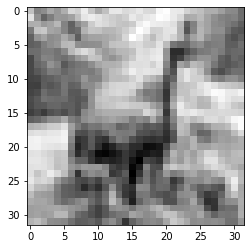

In [183]:
plt.imshow(grayscale_image, cmap=plt.get_cmap('gray'))
plt.show()

In [170]:
class ConvolutionLayer:
    def __init__(self, H2=2, W2=2, D2=1, K=1):
        self.H2 = H2
        self.W2 = W2
        self.D2 = D2
        self.K = K
        self.filters = np.random.normal(scale=0.3, size=(K, H2, W2, D2))
        self.bias = np.random.normal(scale=0.3, size=(K))

    def convolve(self, input):
        H1, W1, _ = input.shape

        H2, W2, D2 = attrgetter('H2', 'W2', 'D2')(self)

        for i in range(H1 - H2 + 1):
            for j in range(W1 - W2 + 1):
                section = input[i: i + H2, j: j + W2]
                yield section, i, j

    def calculate(self, input):
        H1, W1, _ = input.shape

        H2, W2, D2, K, filters, bias = attrgetter(
            'H2', 'W2', 'D2', 'K', 'filters', 'bias')(self)

        feature_maps = np.zeros(((H1 - H2 + 1), (W1 - W2 + 1), K))

        for section, i, j in self.convolve(input):
            feature_maps[i, j] = bias

            if D2 == 1:
                feature_maps[i, j] += np.sum(section * filters, axis=(1, 2))
                continue

            for k in range(D2):
                feature_maps[i, j] += np.sum(section[:, :, k]
                                             * filters[:, :, :, k], axis=(1, 2))

        return feature_maps


In [171]:
class PoolingLayer:
    def __init__(self, pool_size):
        self.pool_size = pool_size

    def pooling(self, input):
        H, W, _ = input.shape

        for i in range(H // self.pool_size):
            for j in range(W // self.pool_size):
                x, y = i * self.pool_size, j * self.pool_size
                section = input[x: x + self.pool_size, y:y + self.pool_size]
                yield section, i, j

    def calculate(self, input):
        H, W, K = input.shape

        pooled_maps = np.zeros((H // self.pool_size, W // self.pool_size, K))

        for section, i, j in self.pooling(input):
            pooled_maps[i, j] = np.amax(section, axis=(0, 1))

        return pooled_maps

In [172]:
class SoftmaxLayer:
    def __init__(self, n_classes, input_size):
        self.n_classes = n_classes
        self.input_size = input_size
        self.w = np.random.normal(scale=0.3, size=(input_size, n_classes))
        self.b = np.random.normal(scale=0.3, size=(n_classes, ))

    def calculate(self, input):
        flattened_input = input.flatten()
        input_size, n_classes = attrgetter('input_size', 'n_classes')(self)

        output = np.dot(flattened_input, self.w) + self.b
        output = output - np.amax(output)
        return np.exp(output) / np.sum(np.exp(output), axis=0)
        

In [173]:
conv_layer1 = ConvolutionLayer(3, 3, 3, 32)
conv_layer2 = ConvolutionLayer(3, 3, 32, 64)

In [174]:
out1 = conv_layer1.calculate(image)
a_out1 = relu(out1)
out2 = conv_layer2.calculate(a_out1)
a_out2 = relu(out2)

Outputs for Layer 1


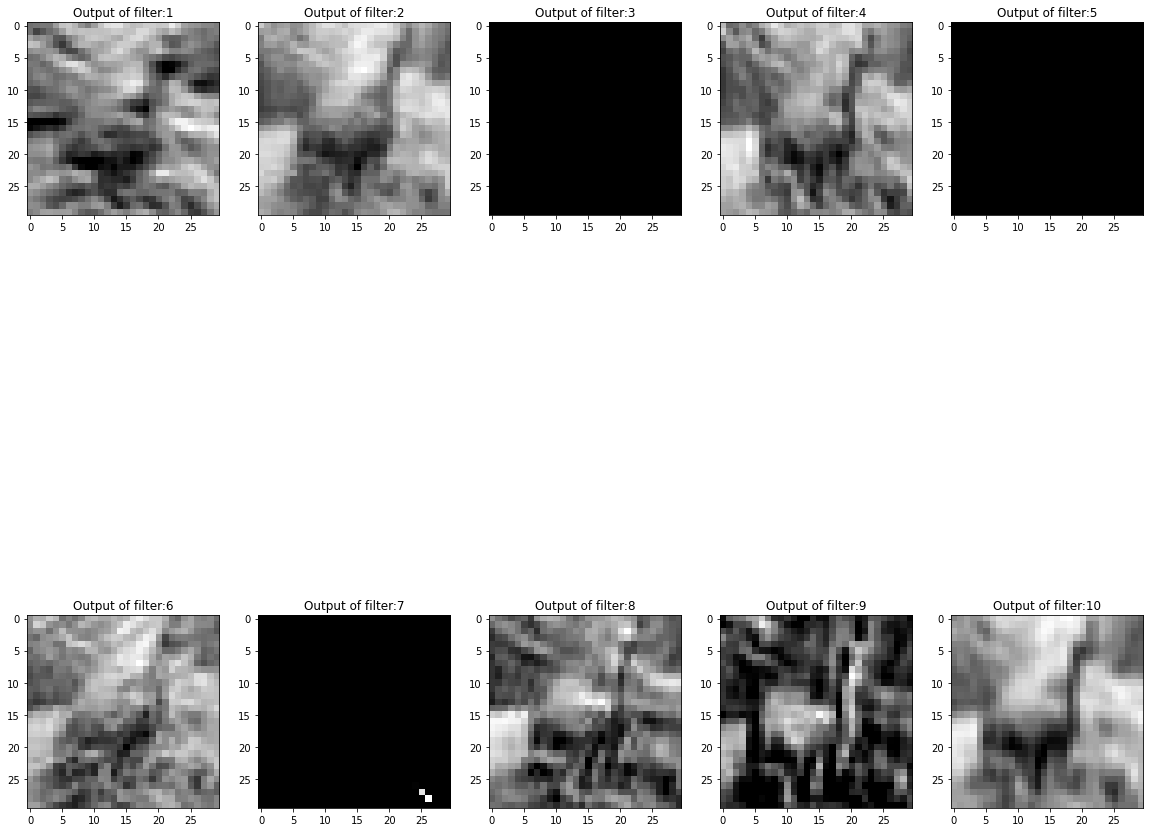

In [175]:
print("Outputs for Layer 1")
fig, axs = plt.subplots(2, 5, figsize=(20, 20), facecolor='white')


for i, ax in enumerate(axs.flat):
    ax.imshow(a_out1[:, :, i], cmap=plt.get_cmap('gray'))
    ax.set_title('Output of filter:{}'.format(i + 1))

plt.show()


Outputs for Layer 2


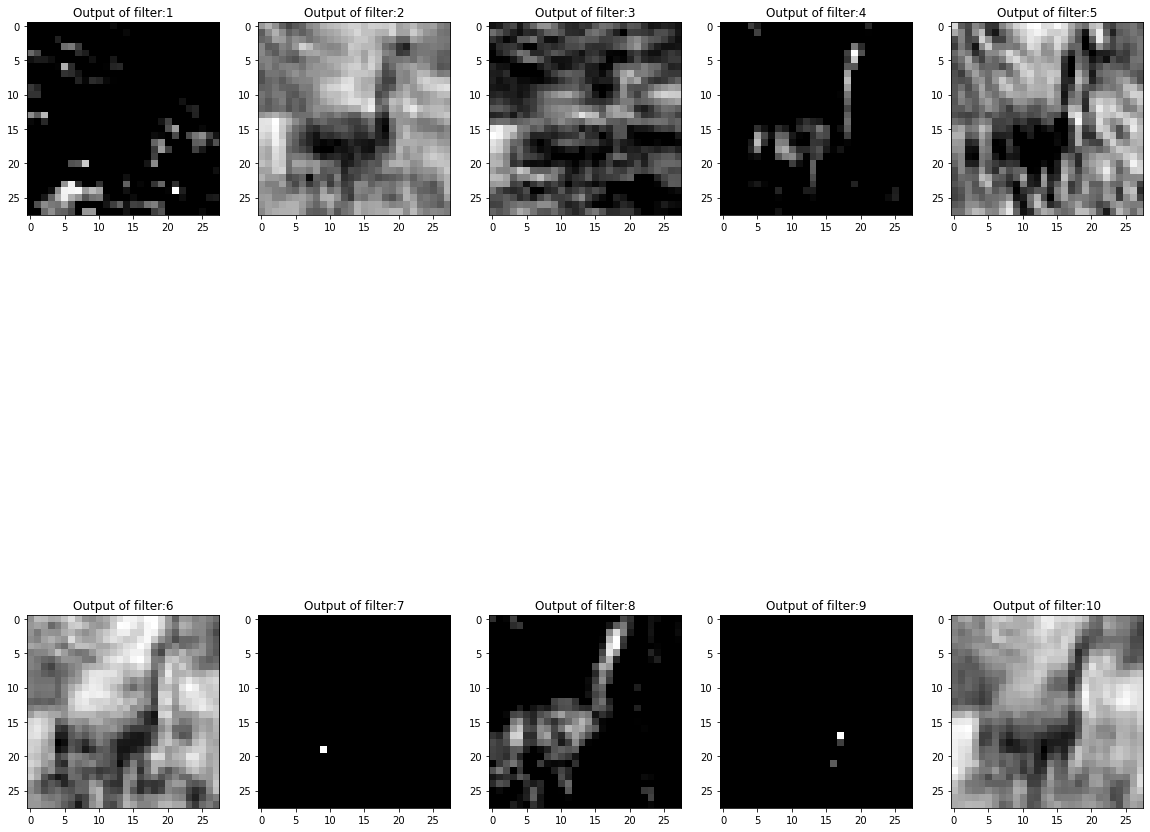

In [176]:
print("Outputs for Layer 2")
fig, axs = plt.subplots(2, 5, figsize=(20, 20), facecolor='white')


for i, ax in enumerate(axs.flat):
    ax.imshow(a_out2[:, :, i], cmap=plt.get_cmap('gray'), )
    ax.set_title('Output of filter:{}'.format(i + 1))
    
plt.show()